In [0]:
# import standard PyTorch modules
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

from PIL import Image, ImageOps
import numpy as np

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

# Invert MNIST images. background-color needs to be write.
class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not F._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [2]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [0]:
# Use standard MNIST dataset
transforms = transforms.Compose([
        Invert(),
        transforms.ToTensor()
    ])

train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms
)

test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms
)

In [0]:
import torch.nn.functional as nnF
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = nnF.relu(t)
    t = nnF.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = nnF.relu(t)
    t = nnF.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = nnF.relu(t)

    # fc2
    t = self.fc2(t)
    t = nnF.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [0]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [0]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [0]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [9]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = nnF.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.200507,0.938183,20.123254,22.004647,0.010,100,False
1,1,2,0.085125,0.975600,20.202437,42.341079,0.010,100,False
2,1,3,0.070723,0.979900,20.252287,62.734056,0.010,100,False
3,1,4,0.061471,0.982917,20.280809,83.144503,0.010,100,False
4,1,5,0.073791,0.979900,20.327158,103.611799,0.010,100,False
5,2,1,0.954118,0.668400,19.449109,20.241029,0.010,1000,False
6,2,2,0.170981,0.946517,19.431405,39.812802,0.010,1000,False
7,2,3,0.114649,0.964800,19.277880,59.218279,0.010,1000,False
8,2,4,0.089524,0.972350,19.378500,78.734183,0.010,1000,False
9,2,5,0.074864,0.976650,19.460661,98.347707,0.010,1000,False


In [0]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [0]:
# bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [12]:
!pip install scikit-plot

In [13]:
# use scikitplot to plot the confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[5813,    1,    3,    0,    5,   19,   30,   13,   21,   18],
       [   1, 6575,   52,   13,   11,    1,    8,   17,   41,   23],
       [  31,   31, 5546,   39,   39,   13,   25,  114,  101,   19],
       [  24,    7,   68, 5648,    0,  172,    1,   60,  108,   43],
       [   3,    7,   20,    0, 5568,    1,   54,    7,    6,  176],
       [  23,    2,    5,   19,    5, 5258,   31,   11,   32,   35],
       [  44,   11,    9,    0,   25,   58, 5754,    0,   17,    0],
       [  11,   11,   47,    9,   28,   12,    0, 6023,   14,  110],
       [  22,   42,   23,   48,   11,   69,   25,   19, 5451,  141],
       [  40,    5,    6,   30,   81,   39,    1,  118,   46, 5583]])

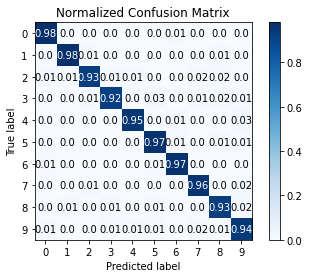

In [14]:
skplt.metrics.plot_confusion_matrix(train_set.targets,train_preds.argmax(dim=1), normalize=True)

In [22]:
# use ngrok to display TensorBoard on Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2020-04-21 11:15:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.226.145.86, 52.5.204.126, 34.192.108.200, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.226.145.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  6.54MB/s    in 2.0s    

2020-04-21 11:15:11 (6.54 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [0]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


In [17]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://95463f57.ngrok.io


Test loader prediction

torch.Size([10, 1, 28, 28])
actual:  [7 2 1 0 4 1 4 9 5 9]
predictions:  [7 2 1 0 4 1 4 9 5 9]
(28, 28)


Text(0.5, 1.0, 'actual: 2 || predicted: 2')

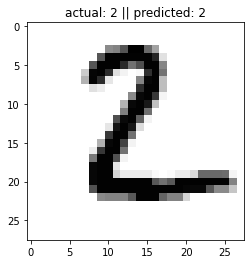

In [18]:
import numpy as np

prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=10)
image_iter = iter(prediction_loader)
images, labels = image_iter.next()
print(images.shape)

output = network(images)

images = images.numpy()
labels = labels.numpy()
print("actual: ", labels)

_, predictions = torch.max(output,1)
predictions = predictions.numpy()
print("predictions: ", predictions)

idx = 1
image = np.squeeze(images[idx])
print(image.shape)
label = labels[idx]
prediction = predictions[idx]
plt.imshow(image, cmap="gray")
plt.title("actual: " + str(label) + " || " + "predicted: " + str(prediction))

## Test My draw

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(486, 454, 3)
(486, 454)
(28, 28)


Text(0.5, 1.0, 'downsampled grayscale image')

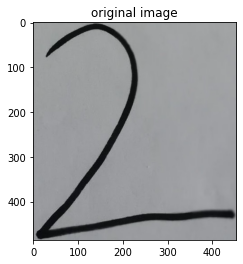

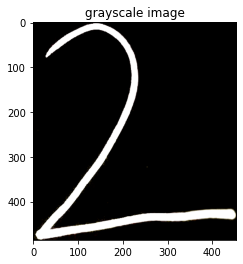

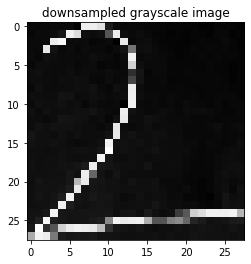

In [21]:
# image edit.
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

inv = Invert()

import cv2
image_path = "2_2.jpg"
image = cv2.imread(image_path)
plt.imshow(image)
plt.title("original image")
image = np.asarray(inv(Image.fromarray(image)))
std = np.std(image)
mean = np.mean(image)
image = (image - mean) / std
plt.figure()
plt.imshow(image, cmap="gray")
plt.title("grayscale image")
print(image.shape)

image = rgb2gray(image)
# image = np.squeeze(image)
print(image.shape)
image = cv2.resize(image, dsize=(28,28) ,interpolation=cv2.INTER_CUBIC)
print(image.shape)

plt.figure()
plt.imshow(image, cmap="gray")
plt.title("downsampled grayscale image")

actual:  2
probabilities:  [2.1657463378232933e-07, 0.00031374942045658827, 0.9965285658836365, 0.0011358766350895166, 1.8536680101988168e-07, 5.088235184302903e-07, 2.3364722778751457e-07, 6.714655228279298e-06, 0.002010426949709654, 3.44866089108109e-06]
labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
probability:  99.65285658836365
prediction:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Text(0.5, 1.0, 'actual: 2 || predicted: 2')

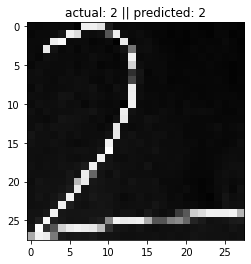

In [22]:
import torchvision.transforms as transforms
# predict

tensor_image = torch.tensor(image).float()
tensor_image = tensor_image.unsqueeze(0).unsqueeze(0)
# std = torch.std(tensor_image)
# mean = torch.mean(tensor_image)
# tensor_image = (tensor_image - mean) / std

output = network(tensor_image)
sm = torch.nn.functional.softmax  # squeeze probabilies between 0 and 1 to see clear
probabilities = sm(output)

print("actual: ", image_path[0])

probability, prediction = torch.max(probabilities,1)
prediction = prediction.item()
probabilities = probabilities.tolist()[0]
print("probabilities: ", probabilities)
labels = list(range(10))
print("labels:", labels)
print("probabilities vs labels:", dict(zip(labels, probabilities)))
print("probability: ", probability.item()*100)
print("prediction: ", prediction)

# idx = 1
# image = np.squeeze(images[idx])
# label = labels[idx]
# prediction = predictions[idx]
plt.imshow(tensor_image.numpy().squeeze(), cmap="gray")
plt.title("actual: " + str(image_path[0]) + " || " + "predicted: " + str(prediction))